<a href="https://colab.research.google.com/github/renaud-florquin/hands_on_AI/blob/master/FireForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!nvidia-smi

Sat Oct  5 13:47:42 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.utils import np_utils

Using TensorFlow backend.


Load the data and check the size of the train and test dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data() 

11493376/11490434 [==============================] - 0s 0us/step


In [3]:
print('x Train: ', x_train.shape)
print('y Train: ', y_train.shape)
print('x Test: ', x_test.shape)
print('y Test: ', y_test.shape)

x Train:  (60000, 28, 28)
y Train:  (60000,)
x Test:  (10000, 28, 28)
y Test:  (10000,)


Display the first images (X) and the corresponding labels (y)

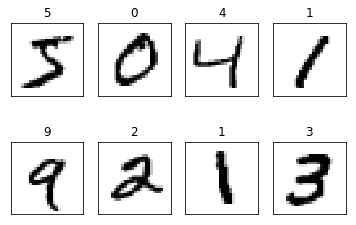

In [4]:
amount = 20
img_rows = 2
img_columns = 4
amount = img_rows * img_columns
fig = plt.figure()

for i in range(amount):
    ax = fig.add_subplot(img_rows, img_columns, 1 + i)
    plt.imshow(x_train[i], cmap='binary')
    plt.title(y_train[i])
    plt.xticks([]) 
    plt.yticks([])

plt.show()

Reshape the X tensor vector of images (N, h, w) to a vector of vectors (N, h*w)

In [0]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])

Normalize the pxel value to a range [0..1]

In [0]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Transform the numerical value of a label to a categorical vector

In [0]:
nb_classes=10
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

In [8]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000, 10)
(10000, 784)
(10000, 10)


In [9]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

## Using Sigmoid

In [0]:
input_layer = tf.keras.layers.Input(shape=(784,))
z = tf.keras.layers.Dense(200)(input_layer)
z = tf.keras.layers.Activation('sigmoid')(z)
z = tf.keras.layers.Dense(100)(z)
z = tf.keras.layers.Activation('sigmoid')(z)
z = tf.keras.layers.Dense(60)(z)
z = tf.keras.layers.Activation('sigmoid')(z)
z = tf.keras.layers.Dense(30)(z)
z = tf.keras.layers.Activation('sigmoid')(z)
z = tf.keras.layers.Dense(nb_classes)(z)
output_layer = tf.keras.layers.Activation('softmax')(z)

model_sigmoid = tf.keras.models.Model(input_layer, output_layer)

In [25]:
model_sigmoid.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_23 (Dense)             (None, 200)               157000    
_________________________________________________________________
activation_23 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_24 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 60)                6060      
_________________________________________________________________
activation_25 (Activation)   (None, 60)                0   

In [0]:
model_sigmoid.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=['accuracy'])

In [27]:
history = model_sigmoid.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 124us/sample - loss: 2.3022 - acc: 0.1108 - val_loss: 2.2998 - val_acc: 0.1135
Epoch 2/100
60000/60000 [==============================] - 7s 122us/sample - loss: 2.3000 - acc: 0.1148 - val_loss: 2.2989 - val_acc: 0.1147
Epoch 3/100
60000/60000 [==============================] - 7s 123us/sample - loss: 2.2984 - acc: 0.1174 - val_loss: 2.2977 - val_acc: 0.1135
Epoch 4/100
60000/60000 [==============================] - 7s 123us/sample - loss: 2.2969 - acc: 0.1232 - val_loss: 2.2954 - val_acc: 0.1135
Epoch 5/100
60000/60000 [==============================] - 7s 122us/sample - loss: 2.2947 - acc: 0.1292 - val_loss: 2.2927 - val_acc: 0.1910
Epoch 6/100
60000/60000 [==============================] - 7s 123us/sample - loss: 2.2917 - acc: 0.1380 - val_loss: 2.2891 - val_acc: 0.1147
Epoch 7/100
60000/60000 [==============================] - 7s 123us/sample - loss: 2.2873 - acc: 0.1491 

Plot the training and validation accuracy per epoch

<Figure size 432x288 with 0 Axes>

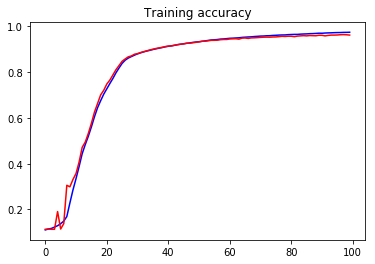

<Figure size 432x288 with 0 Axes>

In [32]:
acc = history.history['acc']
val_acc = history.history['val_acc']
epochs   = range(100) # Get number of epochs

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training accuracy')
plt.figure()


## Model using ReLU

In [0]:
input_layer = tf.keras.layers.Input(shape=(784,))
z = tf.keras.layers.Dense(200)(input_layer)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dense(100)(z)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dense(60)(z)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dense(30)(z)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dense(nb_classes)(z)
output_layer = tf.keras.layers.Activation('softmax')(z)

model_relu = tf.keras.models.Model(input_layer, output_layer)

In [34]:
model_relu.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               157000    
_________________________________________________________________
activation_28 (Activation)   (None, 200)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_29 (Activation)   (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 60)                6060      
_________________________________________________________________
activation_30 (Activation)   (None, 60)                0   

In [0]:
model_relu.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=['accuracy'])

In [36]:
history2 = model_relu.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 8s 131us/sample - loss: 0.7224 - acc: 0.7777 - val_loss: 0.2774 - val_acc: 0.9181
Epoch 2/100
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2429 - acc: 0.9289 - val_loss: 0.1956 - val_acc: 0.9397
Epoch 3/100
60000/60000 [==============================] - 8s 131us/sample - loss: 0.1776 - acc: 0.9480 - val_loss: 0.1644 - val_acc: 0.9514
Epoch 4/100
60000/60000 [==============================] - 7s 125us/sample - loss: 0.1421 - acc: 0.9581 - val_loss: 0.1367 - val_acc: 0.9607
Epoch 5/100
60000/60000 [==============================] - 7s 124us/sample - loss: 0.1184 - acc: 0.9651 - val_loss: 0.1182 - val_acc: 0.9647
Epoch 6/100
60000/60000 [==============================] - 7s 123us/sample - loss: 0.1003 - acc: 0.9703 - val_loss: 0.1227 - val_acc: 0.9658
Epoch 7/100
60000/60000 [==============================] - 7s 123us/sample - loss: 0.0874 - acc: 0.9748 

<Figure size 432x288 with 0 Axes>

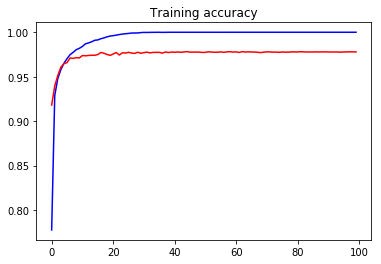

<Figure size 432x288 with 0 Axes>

In [37]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs   = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training accuracy')
plt.figure()

# With Dropout

In [0]:
input_layer = tf.keras.layers.Input(shape=(784,))
z = tf.keras.layers.Dense(200)(input_layer)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dropout(rate=0.4)(z)
z = tf.keras.layers.Dense(100)(z)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dropout(rate=0.4)(z)
z = tf.keras.layers.Dense(60)(z)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dropout(rate=0.4)(z)
z = tf.keras.layers.Dense(30)(z)
z = tf.keras.layers.Activation('relu')(z)
z = tf.keras.layers.Dropout(rate=0.4)(z)
z = tf.keras.layers.Dense(nb_classes)(z)
output_layer = tf.keras.layers.Activation('softmax')(z)

model_relu_dropout = tf.keras.models.Model(input_layer, output_layer)

In [39]:
model_relu_dropout.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_33 (Dense)             (None, 200)               157000    
_________________________________________________________________
activation_33 (Activation)   (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 100)               20100     
_________________________________________________________________
activation_34 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0   

In [0]:
model_relu_dropout.compile(loss='categorical_crossentropy', optimizer="SGD", metrics=['accuracy'])

In [42]:
history3 = model_relu_dropout.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 9s 146us/sample - loss: 1.7751 - acc: 0.3645 - val_loss: 0.7887 - val_acc: 0.7827
Epoch 2/100
60000/60000 [==============================] - 8s 139us/sample - loss: 0.9943 - acc: 0.6572 - val_loss: 0.5003 - val_acc: 0.8559
Epoch 3/100
60000/60000 [==============================] - 8s 140us/sample - loss: 0.7445 - acc: 0.7566 - val_loss: 0.3631 - val_acc: 0.9155
Epoch 4/100
60000/60000 [==============================] - 8s 138us/sample - loss: 0.6104 - acc: 0.8163 - val_loss: 0.2780 - val_acc: 0.9293
Epoch 5/100
60000/60000 [==============================] - 8s 138us/sample - loss: 0.5167 - acc: 0.8531 - val_loss: 0.2276 - val_acc: 0.9425
Epoch 6/100
60000/60000 [==============================] - 8s 140us/sample - loss: 0.4533 - acc: 0.8745 - val_loss: 0.2008 - val_acc: 0.9473
Epoch 7/100
60000/60000 [==============================] - 8s 139us/sample - loss: 0.4115 - acc: 0.8901 

<Figure size 432x288 with 0 Axes>

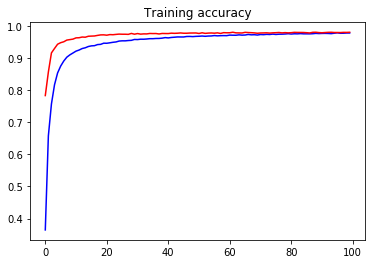

<Figure size 432x288 with 0 Axes>

In [43]:
acc = history3.history['acc']
val_acc = history3.history['val_acc']
epochs   = range(len(acc)) # Get number of epochs

plt.plot(epochs, acc, 'b')
plt.plot(epochs, val_acc, 'r')
plt.title('Training accuracy')
plt.figure()